In [8]:
import numpy as np
from itertools import combinations

from pyquil.paulis import PauliSum, PauliTerm
from pyquil.api import WavefunctionSimulator
from pyquil.unitary_tools import lifted_pauli
from pyquil import Program
from pyquil.gates import H, RX, RZ, CNOT


from time import time
from entropica_qaoa.vqe.cost_function import PrepareAndMeasureOnWFSim
from entropica_qaoa.utilities import random_hamiltonian

sim = WavefunctionSimulator()

import warnings
warnings.filterwarnings('ignore')

In [60]:
def make_prog(qubits):
    prepare_prog = Program()
    for q in qubits:    
        prepare_prog.inst(H(q))

    for q in qubits:
        prepare_prog.inst(RZ(np.random.rand(),q))

    for q in qubits:
        prepare_prog.inst(RX(np.random.rand(),q))
        
    for q1, q2 in combinations(qubits, 2):
        prepare_prog.inst(CNOT(q1, q2))

    return prepare_prog

def exp_val_times(prog, ham, qubits):
    start = time()
    expval = sim.expectation(prog, ham)
    duration = time() - start
    return (0, duration)

def matmul_times(prog, ham, qubits):
    start = time()
    mat = lifted_pauli(ham, qubits)
    mat_dur = time() - start
    
    start = time()
    wf = sim.wavefunction(prog).amplitudes
    expval = wf.conj()@mat@wf
    exp_dur = time() - start
    
    return (mat_dur, exp_dur)
    
def hybrid_times(prog, ham, qubits):
    start = time()
    cost_fun = PrepareAndMeasureOnWFSim(prog, lambda x: {}, ham, sim)
    setup_dur = time() - start
    
    start = time()
    exp_val = cost_fun([])
    exp_dur = time() - start
    
    return (setup_dur, exp_dur)

In [79]:
n_qubits = 8
qubits = range(n_qubits)
ham_full = random_hamiltonian(qubits)
maxterms = len(ham_full)

prog = make_prog(qubits)
exp_val_res = np.zeros((maxterms, 2))
matmul_res = np.zeros((maxterms, 2))
hybrid_res = np.zeros((maxterms, 2))

for nterms in range(1,maxterms):
    print("nterms= ", nterms)
    ham = PauliSum(ham_full[:nterms])
    exp_val_res[nterms] = exp_val_times(prog, ham, qubits)
    matmul_res[nterms] = matmul_times(prog, ham, qubits)
    hybrid_res[nterms] = hybrid_times(prog, ham, qubits)

nterms=  1
nterms=  2
nterms=  3
nterms=  4
nterms=  5
nterms=  6
nterms=  7
nterms=  8
nterms=  9
nterms=  10
nterms=  11


In [62]:
import matplotlib.pyplot as plt

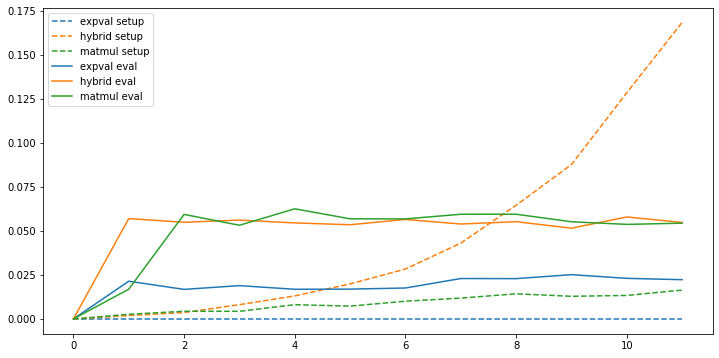

In [80]:
plt.figure(figsize=(12,6))
plt.plot(exp_val_res[:,0], label="expval setup", linestyle="--", color="C0")
plt.plot(hybrid_res[:,0], label="hybrid setup", linestyle="--", color="C1")
plt.plot(matmul_res[:,0], label="matmul setup", linestyle="--", color="C2")
plt.plot(exp_val_res[:,1], label="expval eval", color="C0")
plt.plot(hybrid_res[:,1], label="hybrid eval", color="C1")
plt.plot(matmul_res[:,1], label="matmul eval", color="C2")
plt.legend()

In [6]:
def runtime_func(n_qubits, upper_lim):
    
    """
    n_qubits is total number of qubits
    
    builds a ZZ cost Hamiltonian with all terms of form Z_i*Z_j from i = 0, j = 1 up to
    i = upper_lim-1, j = upper_lim 
    """
    
    ham = []
    for i in range(upper_lim-1):
        for j in range(i+1,upper_lim):

            term = PauliTerm("Z", i, np.random.rand())*PauliTerm("Z", j) 
            ham.append(term)

    ham = PauliSum(ham)
    
    n_terms = len(ham.terms) # total number of terms in the PauliSum
    
    # Build a QAOA-like circuit - not really important here
    prepare_prog = Program()
    for i in range(n_qubits):    
        prepare_prog.inst(H(i))
    
    for i in range(n_qubits):
        prepare_prog.inst(RZ(np.random.rand(),i))
    
    for i in range(n_qubits):
        prepare_prog.inst(RX(np.random.rand(),i))
    
    for q1, q2 in combinations(range(n_qubits), 2):
        prepare_prog.inst(CNOT(q1, q2))
    
    # time taken to run on Rigetti QVM
    start_exp = time()
    Expval1 = sim.expectation(prepare_prog, ham)
    end_exp = time()

    # time taken to run in EntropicaQAOA
    start_new = time()
    cost_fun = PrepareAndMeasureOnWFSim(prepare_prog,lambda x:{}, ham,sim)
    cost_fun([])
    end_new = time()
    
    # time taken to run using matrices
    start_matr = time()
    wavefunc = sim.wavefunction(prepare_prog).amplitudes
    ham_matrix = lifted_pauli(ham, np.arange(n_qubits))
    Expval2 = np.vdot(wavefunc, np.dot(ham_matrix,wavefunc))
    end_matr = time()
    
    duration_exp = end_exp - start_exp
    duration_new = end_new - start_new
    duration_matr = end_matr - start_matr
    
    return n_terms, duration_exp, duration_matr, duration_new

In [9]:
n_qubits = 12
upper_lim = np.arange(3,n_qubits +1)

runtime_exp = np.zeros(len(upper_lim))
runtime_matr = np.zeros(len(upper_lim))
runtime_new = np.zeros(len(upper_lim))
n_terms = np.zeros(len(upper_lim))
for i in range(len(upper_lim)):
    print(i)

    terms_, time_exp, time_matr, time_new = runtime_func(n_qubits, upper_lim[i])

    n_terms[i] = terms_
    runtime_exp[i] = time_exp
    runtime_matr[i] = time_matr
    runtime_new[i] = time_new

0
1
2
3
4
5
6
7
8
9


In [4]:
import matplotlib.pyplot as plt

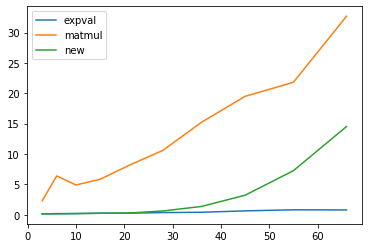

In [16]:
plt.plot(n_terms,runtime_exp, label="expval")
plt.plot(n_terms, runtime_matr, label="matmul")
plt.plot(n_terms, runtime_new, label="new")
plt.legend()
#plt.semilogy()
plt.show()